# 0 Download the dataset

In [ ]:
import os
import yaml
import gdown
import zipfile
import shutil


def download_and_unzip(zip_url, output_folder='./Dataset',  folders_to_delete=None):
    # Extract the Google Drive ID from the URL
    file_id = zip_url.split('/')[-2]
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Check if download URL has public permissions set
    try:
        zip_file = "downloaded_zip_file.zip"
        gdown.download(download_url, zip_file, quiet=False)

        # Create output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Unzip the downloaded file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(output_folder)

        print(f"Files extracted to '{output_folder}'")

        # Clean up the downloaded zip file
        os.remove(zip_file)

        # Clean up the Dataset folder
        if folders_to_delete:
            for folder in folders_to_delete:
                folder_path = os.path.join(output_folder, folder)
                if os.path.exists(folder_path) and os.path.isdir(folder_path):
                    shutil.rmtree(folder_path)
                    print(f"Deleted folder: {folder_path}")
                else:
                    print(f"Folder not found or not a directory: {folder_path}")

        # Load the existing data.yaml file
        data_yaml_path = './Dataset/data.yaml'
        with open(data_yaml_path, 'r') as file:
            data_config = yaml.safe_load(file)

        # Update paths to be relative
        data_config['train'] = './images/train'
        data_config['val'] = './images/val'
        data_config['test'] = './images/test'

        # Write the updated content back to the data.yaml file with proper formatting for arrays
        with open(data_yaml_path, 'w') as file:
            yaml.dump(data_config, file, default_flow_style=None, sort_keys=False)

        print(f"Updated '{data_yaml_path}' with relative paths.")

    except gdown.exceptions.FileURLRetrievalError as e:
        print("Failed to retrieve file url. Please check the permissions on Google Drive and try again.")
        print(e)

# Example usage:
zip_url = "https://drive.google.com/file/d/1UknFvrQTOlIAxhkf3CHvbaSSsHru-fPP/view?usp=sharing"
download_and_unzip(zip_url, folders_to_delete=['.config', '.ipynb_checkpoints'])


Downloading...
From (original): https://drive.google.com/uc?id=1UknFvrQTOlIAxhkf3CHvbaSSsHru-fPP
From (redirected): https://drive.google.com/uc?id=1UknFvrQTOlIAxhkf3CHvbaSSsHru-fPP&confirm=t&uuid=be6f545b-df84-4400-8ffb-8c3237972fd5
To: /content/downloaded_zip_file.zip
100%|██████████| 154M/154M [00:01<00:00, 82.9MB/s]


Files extracted to './Dataset'
Deleted folder: ./Dataset/.config
Deleted folder: ./Dataset/.ipynb_checkpoints
Updated './Dataset/data.yaml' with relative paths.


# 1 Evaluating baseline finetuned model

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import os
from tqdm import tqdm
import time

# Define a custom model class to include the forward method
class FineTunedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedResNet18, self).__init__()
        self.resnet18 = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1)
        # Modify the fully connected layer to match the number of classes
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

    def forward(self, x):
        # Define the forward pass
        return self.resnet18(x)

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

        # Get all image files in the images directory
        self.image_files = sorted(os.listdir(images_dir))  # Sorting to align with labels
        self.label_files = sorted(os.listdir(labels_dir))  # Sorting to align with images

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')  # Convert to RGB if not already

        # Load label
        label_path = os.path.join(self.labels_dir, self.label_files[idx])
        with open(label_path, 'r') as f:
            label_idx = int(f.read().strip().split(" ")[0])  # Read label from file

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Load the fine-tuned model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FineTunedResNet18(29)
state_dict = torch.load("resnet18_finetuned.pt")
model.load_state_dict(state_dict)
model = model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
test_dataset = CustomDataset(images_dir='Dataset/images/test', labels_dir='Dataset/labels/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    start = time.time()
    batches = 0
    for images, labels in tqdm(test_loader):
        batches += 1
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    end = time.time()
    batch_size = 32
    num_examples_per_second = batches * batch_size / (end - start)
    print("%.1f examples/second" % num_examples_per_second)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


<ipython-input-12-49c93ee65865>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("resnet18_finetuned.pt")
100%|██████████| 47/47 [00:07<00:00,  6.35

203.0 examples/second
Test Accuracy: 99.80%


# 2 AWQ

In [ ]:
class AWQFineTunedResNet18(FineTunedResNet18):
    def __init__(self, num_classes):
        super(AWQFineTunedResNet18, self).__init__(num_classes)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        self.skip_add = nn.quantized.FloatFunctional()

    def _make_layer_quantized(self, x, layer):
        identity = x

        # First conv block
        out = layer.conv1(x)
        out = layer.bn1(out)
        out = layer.relu(out)

        # Second conv block
        out = layer.conv2(out)
        out = layer.bn2(out)

        # Handle downsample
        if hasattr(layer, 'downsample') and layer.downsample is not None:
            identity = layer.downsample(x)

        # Quantized addition
        out = self.skip_add.add(out, identity)
        out = layer.relu(out)
        return out

    def forward(self, x):
        # Initial quantization
        x = self.quant(x)

        # Initial conv + pooling
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        # Layer blocks with quantized residual connections
        for block in self.resnet18.layer1:
            x = self._make_layer_quantized(x, block)
        for block in self.resnet18.layer2:
            x = self._make_layer_quantized(x, block)
        for block in self.resnet18.layer3:
            x = self._make_layer_quantized(x, block)
        for block in self.resnet18.layer4:
            x = self._make_layer_quantized(x, block)

        x = self.resnet18.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet18.fc(x)

        # Final dequantization
        x = self.dequant(x)
        return x

In [ ]:
# Load the finetuned baseline model
finetuned_model = FineTunedResNet18(num_classes=29)
finetuned_state = torch.load('resnet18_finetuned.pt')
finetuned_model.load_state_dict(finetuned_state)

# Load the quantized model
quantized_model = AWQFineTunedResNet18(num_classes=29)
quantized_state = torch.load('resnet18_awq_quantized.pt')
for key in quantized_state['model_state_dict']:
    tensor = quantized_state['model_state_dict'][key]
    if isinstance(tensor, torch.Tensor) and tensor.is_quantized:
        quantized_state['model_state_dict'][key] = tensor.dequantize()

quantized_model.load_state_dict(quantized_state['model_state_dict'], strict=False)

<ipython-input-16-2d0d81ba07e0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetuned_state = torch.load('resnet18_finetuned.pt')
<ipython-input-16-2d0d81ba07e0>:8: Fut

_IncompatibleKeys(missing_keys=['resnet18.bn1.weight', 'resnet18.bn1.bias', 'resnet18.bn1.running_mean', 'resnet18.bn1.running_var', 'resnet18.fc.weight', 'resnet18.fc.bias'], unexpected_keys=['resnet18.conv1.bias', 'resnet18.conv1.scale', 'resnet18.conv1.zero_point', 'resnet18.layer1.0.conv1.bias', 'resnet18.layer1.0.conv1.scale', 'resnet18.layer1.0.conv1.zero_point', 'resnet18.layer1.0.bn1.scale', 'resnet18.layer1.0.bn1.zero_point', 'resnet18.layer1.0.conv2.bias', 'resnet18.layer1.0.conv2.scale', 'resnet18.layer1.0.conv2.zero_point', 'resnet18.layer1.0.bn2.scale', 'resnet18.layer1.0.bn2.zero_point', 'resnet18.layer1.1.conv1.bias', 'resnet18.layer1.1.conv1.scale', 'resnet18.layer1.1.conv1.zero_point', 'resnet18.layer1.1.bn1.scale', 'resnet18.layer1.1.bn1.zero_point', 'resnet18.layer1.1.conv2.bias', 'resnet18.layer1.1.conv2.scale', 'resnet18.layer1.1.conv2.zero_point', 'resnet18.layer1.1.bn2.scale', 'resnet18.layer1.1.bn2.zero_point', 'resnet18.layer2.0.conv1.bias', 'resnet18.layer2.0.

In [ ]:
import matplotlib.pyplot as plt

def plot_weight_histograms(finetuned_model, quantized_model):
    # Extract weights from the first convolutional layer
    finetuned_weights = finetuned_model.resnet18.conv1.weight.data.cpu().numpy().flatten()
    quantized_weights = quantized_model.resnet18.conv1.weight.data.cpu().numpy().flatten()

    # Calculate global min and max for the x-axis scale
    global_min = min(finetuned_weights.min(), quantized_weights.min())
    global_max = max(finetuned_weights.max(), quantized_weights.max())

    # Plot histograms side-by-side
    plt.figure(figsize=(12, 6))

    # Finetuned model weights histogram
    plt.subplot(1, 2, 1)
    plt.hist(finetuned_weights, bins=50, alpha=0.7, color='blue')
    plt.title("Finetuned Model Weights Distribution")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.xlim(finetuned_weights.min(), finetuned_weights.max())
    plt.ylim(0, 6000)

    # Quantized model weights histogram
    plt.subplot(1, 2, 2)
    plt.hist(quantized_weights, bins=50, alpha=0.7, color='orange')
    plt.title("Quantized Model Weights Distribution")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.xlim(quantized_weights.min(), quantized_weights.max())
    plt.ylim(0, 6000)

    plt.tight_layout()
    plt.show()
    print(finetuned_weights.min())
    print(finetuned_weights.max())
    print(quantized_weights.min())
    print(quantized_weights.max())

plot_weight_histograms(finetuned_model, quantized_model)



NameError: name 'finetuned_model' is not defined

In [ ]:
def prepare_model_for_awq(model, calibration_loader, alpha=0.2, per_channel_scaling_factor=1.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # 1. Capture Activations Using Hooks
    activations = {}
    def save_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook

    for name, layer in model.resnet18.named_modules():
        if isinstance(layer, nn.Conv2d):
            layer.register_forward_hook(save_activation(name))

    # 2. Forward pass
    calibration_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        for images, labels in calibration_loader:
            images = images.to(device)
            _ = model(images)
            break

    # 3. Analyze Activation Distributions
    activation_stats = {}

    for name, act in activations.items():
        B, C, H, W = act.shape
        per_channel_abs_mean = act.abs().mean(dim=[0,2,3])
        activation_stats[name] = per_channel_abs_mean

    # 4. Compute Per-Channel Scaling
    for name, layer in model.resnet18.named_modules():
        if isinstance(layer, nn.Conv2d) and name in activation_stats:
            per_channel_abs_mean = activation_stats[name]
            s_c = per_channel_abs_mean**alpha
            s_c = s_c.clamp(min=1e-8)

            s_c_reshaped = s_c.view(-1,1,1,1)
            weights = layer.weight.data
            layer.weight.data *= s_c_reshaped

    # 5. Identify Outliers Per Channel
    outliers = {}

    for name, layer in model.resnet18.named_modules():
        if isinstance(layer, nn.Conv2d):
            weights = layer.weight.data
            outlier_threshold = weights.abs().quantile(0.99).item()

            outliers_mask = weights.abs() > outlier_threshold
            outliers[name] = outliers_mask

    # 6. Quantize Non-Outliers
    for name, layer in model.resnet18.named_modules():
        if name in outliers:
            weights = layer.weight.data

            # Extra scaling for salient weights
            outlier_weights = weights[outliers[name]].float()
            outlier_weights *= per_channel_scaling_factor
            weights[outliers[name]] = outlier_weights

            non_outliers = ~outliers[name]
            non_outlier_weights = weights[non_outliers].float()

            # Compute scale for quantization
            w_min = non_outlier_weights.min().item()
            w_max = non_outlier_weights.max().item()
            scale = (w_max - w_min) / 255.0 if (w_max > w_min) else 1e-4

            # Quantize
            quantized_weights = torch.quantize_per_tensor(
                non_outlier_weights, scale=scale, zero_point=0, dtype=torch.qint8
            ).dequantize()

            # weights[non_outliers] = quantized_weights.int_repr().to(dtype=torch.float)
            weights[non_outliers] = quantized_weights

    # Proceed with Quantization
    model = model.to("cpu")
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    torch.backends.quantized.engine = 'fbgemm'

    torch.quantization.fuse_modules(
        model.resnet18,
        [['conv1', 'bn1', 'relu']],
        inplace=True
    )

    torch.quantization.prepare(model, inplace=True)

    # Calibration with data
    with torch.no_grad():
        for i, (data, _) in enumerate(calibration_loader):
            model(data)
            if i >= 100:  # Use more calibration batches
                break

    torch.quantization.convert(model, inplace=True)
    return model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np

device = torch.device('cpu')

alphas = np.linspace(0.1, 0.3, 5)
salient_scales = np.linspace(1.25, 2, 4)
accuracies = {}

best_model = AWQFineTunedResNet18(num_classes=29)
best_accuracy = 0.0

alphas = [0.2]
salient_scales = [1.5]

for salient_scale in salient_scales:
    for alpha in alphas:
        print(f'Alpha: {alpha}, Salient Scale: {salient_scale}')

        model = AWQFineTunedResNet18(num_classes=29)

        # Load pre-trained weights
        state_dict = torch.load('resnet18_finetuned.pt', map_location=device)
        model.load_state_dict(state_dict, strict=False)

        # Data transformation
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        # Create calibration dataset and loader
        cal_dataset = CustomDataset(
            images_dir='Dataset/images/val',
            labels_dir='Dataset/labels/val',
            transform=transform
        )
        calibration_loader = DataLoader(
            cal_dataset,
            batch_size=32,
            shuffle=False
        )

        # Apply AWQ quantization preprocessing
        model = prepare_model_for_awq(model, calibration_loader, alpha=alpha,
                                      per_channel_scaling_factor=salient_scale)

        # Evaluate the model
        test_dataset = CustomDataset(
            images_dir='Dataset/images/test',
            labels_dir='Dataset/labels/test',
            transform=transform
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=32,
            shuffle=False
        )

        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            start = time.time()
            batches = 0
            for data, labels in test_loader:
                batches += 1
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            end = time.time()
            batch_size = 32
            num_examples_per_second = batches * batch_size / (end - start)
            print("%.1f examples/second" % num_examples_per_second)

        accuracy = 100 * correct/total
        print(f'Accuracy on test set: {accuracy}')
        if (accuracy > best_accuracy):
            best_model = model
            best_accuracy = accuracy

        accuracies[(alpha, salient_scale)] = accuracy


# # Save the quantized model
# torch.save({
#     'model_state_dict': best_model.state_dict(),
#     'accuracy': 100 * correct / total,
# }, 'resnet18_best_awq_quantized.pt')
# print("Best Model saved as resnet18_best_awq_quantized.pt")


Alpha: 0.2, Salient Scale: 1.5


<ipython-input-4-bfce1f375f33>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('resnet18_finetuned.pt', map_location=device)
/usr/local/lib/python3

24.9 examples/second
Accuracy on test set: 75.53333333333333


In [ ]:
device = torch.device("cuda")
print(device)
model = model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
test_dataset = CustomDataset(images_dir='Dataset/images/test', labels_dir='Dataset/labels/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    start = time.time()
    batches = 0
    for images, labels in tqdm(test_loader):
        batches += 1
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    end = time.time()
    batch_size = 32
    num_examples_per_second = batches * batch_size / (end - start)
    print("%.1f examples/second" % num_examples_per_second)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


cuda


  0%|          | 0/47 [00:00<?, ?it/s]

Text(33.22222222222222, 0.5, 'Salient Scale')

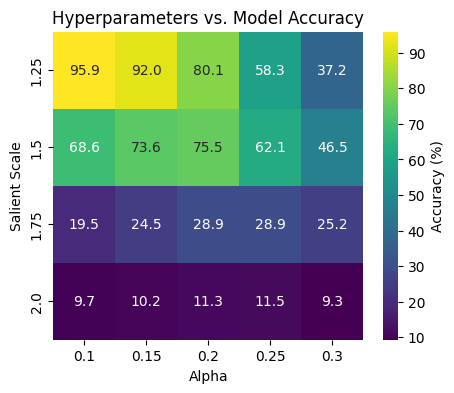

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import pandas as pd

alphas = np.linspace(0.1, 0.3, 5)
salient_scales = np.linspace(1.25, 2, 4)
accuracies = np.array([
    [95.933, 68.600, 19.533, 9.733],
    [92.000, 73.600, 24.533, 10.200],
    [80.066, 75.533, 28.933, 11.266],
    [58.266, 62.133, 28.933, 11.533],
    [37.200, 46.533, 25.200, 9.2666]
])


X, Y = np.meshgrid(alphas, salient_scales)
Z = accuracies.T  # Transpose if necessary to match dimensions

df = pd.DataFrame(accuracies.T, index=salient_scales, columns=alphas)

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label': 'Accuracy (%)'})
plt.title("Hyperparameters vs. Model Accuracy")
plt.xlabel("Alpha")
plt.ylabel("Salient Scale")